#####Standard Imports

In [ ]:
import numpy as np
import scipy.integrate as integrate
import time, copy
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm 

#####AirfoilSpec is the parent class , includes methods for derivatives .

In [ ]:
class AirfoilSpec(object):
    """ Template class for specifying airfoil

        There are methods that give the z-coordinates of the camber & thickness
        distributions, upper & lower surface locations, and derivatives of all
        of these, all taking x-coordinates along the chord as input. All these
        methods work equally well with scalar or 1D numpy array inputs, and
        their outputs are like their inputs. Also, all x- and z-coordinates are
        normalized by the chord length (LE = 0; TE = 1).
    """

    def __init__(self,**kwarg):
        if 'name' in kwarg:
            self.name = kwarg['name']

    # x-derivative of any relevant x-dependent function at a given x-coordinate
    # along chord
    #
    # INPUTS:
    # x_by_c : x-coordinate along chord
    # z      : Handle to function giving variation with x_by_c
    # deltaX : Size of x-step for finite difference approximations
    #
    # OUTPUTS:
    # dz : x-derivative of given z-function
    def dz_dx(self,x_by_c,z,deltaX=0.0001):
        # We start by converting the given x_by_c to a 1D (singleton) numpy
        # array if it is a scalar, since all the subsequent steps are vectorized
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) #Create a new singleton array
        else:
            x_copy = x_by_c
        # Find indices of x_copy that are too far to the left (too close to 0) 
        # to pursue 2nd-order accurate central differences
        iL = x_copy < deltaX
        # Find indices of x_copy that are well inside the range [0,1] so as to
        # allow pursuit of 2nd-order accurate central differences
        iM = np.logical_and(x_copy >= deltaX,x_copy <= 1-deltaX)
        # Find indices of x_copy that are too far to the right (too close to 1)
        # to pursue 2nd-order accurate central differences
        iR = x_copy > 1-deltaX
        # Pre-allocate output array like input array
        dz = np.zeros_like(x_copy)
        # Evaluate 1st-order accurate forward differences at leftward points
        dz[iL] = (z(x_copy[iL]+deltaX) -z(x_copy[iL]))/deltaX
        # Evaluate 2nd-order accurate central difference at inner points
        dz[iM] = (z(x_copy[iM]+deltaX) - z(x_copy[iM]-deltaX))/(2*deltaX)
        # Evaluate 1st-order accurate backward differences at rightward points
        dz[iR] = (z(x_copy[iR]) - z(x_copy[iR]-deltaX))/deltaX        
        if singleton:
            dz = dz[0] #Output must be a scalar since input was scalar
        return dz
    
    # Camber distribution of airfoil at a given x-coordinate along chord; this
    # must be coded in the child class
    # def zc_by_c(self,x_by_c):
    #     pass

    # x-derivative of camber distribution at a given x-coordinate along chord
    def dzc_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zc_by_c,deltaX=deltaX)
    
    # Semi-thickness distribution at a given x-coordinate along chord; this
    # must be coded in the child class
    # def zt_by_c(self,x_by_c):
    #     pass
    
    # x-derivative of semi-thickness distribution at a given x-coordinate along
    # chord
    def dzt_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zt_by_c,deltaX=deltaX)

    # z-coordinate of upper surface at a given x-coordinate along chord
    def zu_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) + self.zt_by_c(x_by_c)

    # z-coordinate of lower surface at a given x-coordinate along chord
    def zl_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) - self.zt_by_c(x_by_c)

    # Plot the airfoil geometry, in the supplied axes if given
    def plot(self,axes=None):
        # Create a single plot for both upper and lower surfaces, starting from
        # the LE, going to the TE along the upper surface, and then returning
        # to the LE along the lower surface
        x_by_c = np.linspace(0,1,100)    #x/c for upper surface
        # x/c for lower surface; don't duplicate TE; duplicate LE to close loop
        x_by_c_flip = x_by_c[-2::-1]
        # Final array of x-coordinates to plot
        X = np.concatenate((x_by_c,x_by_c_flip))
        # Final array of z-coordinates to plot
        Z = np.concatenate((self.zu_by_c(x_by_c),self.zl_by_c(x_by_c_flip)))
        if axes is None:
            plt.figure()
            axes = plt.gca()
        axes.plot(X,Z)
        axes.set_xlabel('x/c');  axes.set_ylabel('z/c')
        axes.set_aspect('equal', 'box')
        if hasattr(self,'name'):
            axes.set_title(self.name)
        else:
            axes.set_title('Airfoil geometry')

#####NACA4digit contains methods for z_t , z_c and inherits from AirfoilSpec

In [ ]:
class NACA4digit(AirfoilSpec):
    """ Implementation of class derived from AirfoilSpec for defining the
        geometry of a NACA 4-digit airfoil

        airfoil = NACA4digit(digits='2412'), or
        airfoil = NACA4digit(mCmbr=0.02,pCmbr=0.4,mThk=0.12)
    """
    def __init__(self,**kwarg):
        if 'digits' in kwarg:
            self.digits = kwarg['digits']
            del kwarg['digits']
            self.mThk = float(self.digits[-2:])/100
            self.mCmbr = float(self.digits[0])/100
            self.pCmbr = float(self.digits[1])/10
        else:
            self.mThk = kwarg['mThk'];   del kwarg['mThk']
            self.mCmbr = kwarg['mCmbr']; del kwarg['mCmbr']
            self.pCmbr = kwarg['pCmbr']; del kwarg['pCmbr']
            self.digits='%02d%d%d'%(self.mCmbr*100,self.pCmbr*10,self.mThk*100)
        self.name = 'NACA '+self.digits
        super().__init__(**kwarg)

    # Camber function of NACA 4-digit airfoil series with maximum fractional
    # camber mCmbr and its fractional position pCmbr available as class
    # attributes already
    def zc_by_c(self,x_by_c):
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) #Create a new singleton array
        else:
            x_copy = x_by_c
        cmbr = np.zeros_like(x_copy)
        iL = x_copy <= self.pCmbr
        iT = x_copy > self.pCmbr
        cmbr[iL] = self.mCmbr/self.pCmbr**2*(2*self.pCmbr*x_copy[iL] \
            -np.square(x_copy[iL]))
        cmbr[iT] = self.mCmbr/(1-self.pCmbr)**2 \
            *(1-2*self.pCmbr+2*self.pCmbr*x_copy[iT]-np.square(x_copy[iT]))
        if singleton:
            cmbr = cmbr[0] #Output must be a scalar since input was scalar
        return cmbr

    # Semi-thickness function of NACA 4-digit airfoil series with maximum 
    # fractional thickness mThk available as a class attribute already
    def zt_by_c(self,x_by_c):
      A = 1.4845
      B = -0.630
      C = -1.758
      D = 1.4215
      E = -0.5075
      if np.any(x_by_c < 0) or np.any(x_by_c > 1):
        raise Exception('Argument cannot be outside [0, 1]')
      return (self.mThk)*(A*np.sqrt(x_by_c) + x_by_c*(B + x_by_c*(C + x_by_c*(D + x_by_c*E))))

In [ ]:
# def visualizeAirfoil(airfoil):
#     """ Function that takes an instantiated object of a class that specifies
#         airfoil geometry, and does something with it.

#         In this case, it visualizes the airfoil and plots the derivatives of
#         its camber and thickness distributions
        
#         INPUTS:
#         airfoil : Instance of airfoil geometry specification class

#         OUTPUTS:
#         Plots of Airfoil Shape , dz_c/dx and dz_t/dx
#     """
#     # Plot the airfoil
#     airfoil.plot()
#     # Prepare x-coordinate array for plotting derivatives; omit LE where thickness
#     # derivative is theoretically infinite for the NACA 4 digit airfoil family
#     x_by_c = np.linspace(0,1,100);  x_by_c = x_by_c[1:]
#     plt.figure()
#     plt.subplot(2,1,1)
#     plt.plot(x_by_c,airfoil.dzc_dx(x_by_c));
#     plt.ylabel('dz_c/dx')
#     plt.subplot(2,1,2)
#     plt.plot(x_by_c,airfoil.dzt_dx(x_by_c));
#     plt.ylabel('dz_t/dx')
#     plt.xlabel('x/c');

# visualizeAirfoil(airfoil=airfoil)

####Question 2
Write a Python class with a method to solve for the flow around an arbitrary airfoil
using thin-airfoil theory ((with both vortex and source sheets). Set an object of an airfoil
specification class obtained in the previous step as an attribute of the current class.


We proved that all potential flow problems can be represented using sources and vortex sheets

First we see the solutions for the 3 separate problems :
Before we write anything , x means x coordinate per unit chord .
* Angle of Attack problem
$$
\gamma(x)=2V_\infty \sqrt{\frac{1-x}{x}}\\
q(x)=0
$$
* Camber problem
$$
\gamma(\theta)=2V_\infty\bigg(A_0\frac{1+\cos\theta}{\sin\theta}+\sum_{n=1}^{\infty}A_n\sin{n\theta}\bigg)\\
q(x)=0
$$
* Thickness problem
$$
\gamma(\theta)=0\\
q(x)=2V_\infty z'_t(x)
$$


From the solutions , we need to find $c_l$ , $c_{m,c/4} $ , $c_p$ , these are the sectional coefficients of the prescribed airfoil .
We know that $c_p$ is different for upper and lower surfaces in total , by vortex sheet singularity , we get :
$$
c_{p,u}(x)=-\frac{\gamma(x)}{V_\infty} , c_{p,l}(x)=\frac{\gamma(x)}{V_\infty}
$$
And for the thickness problem $c_p$ contribution is same for upper and lower surface :
$$
c_{p,thickness}=-\frac{2}{\pi}\int^1_0\frac{z'_t(\zeta)}{x-\zeta}d\zeta
$$
Now we add and find the final $c_{p,u}$ and $c_{p,l}$ 
$$
c_{p,u}(x)=-\frac{\gamma(x)}{V_\infty} -\frac{2}{\pi}\int^1_0\frac{z'_t(\zeta)}{x-\zeta}d\zeta \\
c_{p,l}(x)=\frac{\gamma(x)}{V_\infty}-\frac{2}{\pi}\int^1_0\frac{z'_t(\zeta)}{x-\zeta}d\zeta
$$
For this we need $\gamma(x)$ , and $\gamma$ contribution is only from AoA and camber problem which is implemented directly into the code with conversions from x/c space to theta space as follows :
$$
x/c=\frac{(1-\cos\theta)}{2}
$$
And for finding $\gamma$ we have to find the values of $A_n$ 
$$
A_0=-\frac{1}{\pi}\int^\pi_0\frac{dz_c}{dx}(\theta)\space d\theta\\
A_n=\frac{2}{\pi}\int^\pi_0\frac{dz_c}{dx}(\theta)\cos n\theta \space d\theta \space for \space n\geq 1
$$

For solving the flow problem using thin airfoil theory , first we calculate the fourier coefficients for camber problem . Some controls like the number of points for plotting $c_p$ vs $x/c$ are absent since the class is not written like a script but a block code .

In [ ]:
class ThinAirfoilSolver():
  # """  
  #       A Python class with a method to solve for the flow around an arbitrary
  #       airfoil using thin-airfoil theory
  # """

## init definition with optional parameters for fourier coefficient count
  def __init__(self,airfoil,orderofA=10):
    self.airfoil=airfoil
    self.orderofA=orderofA
    self.A=self.printa()
## end init definition ( note that A is an attribute of the object since its we 
## know As are dependent only on the airfoil class)

## method to generate An

  def printa(self):
#  '''
#       Returns the fourier coefficients for the camber problem 
#       (which is independent of alpha)

#  '''
    A=[]
    for i in range(self.orderofA+1):
      if i==0:
        def I(theta):
          return self.airfoil.dzc_dx((1-np.cos(theta))/2)
        A.append((-1/np.pi)*integrate.quad(I,0,np.pi,limit=2000)[0])
      else :
        def Ji(theta):
          return self.airfoil.dzc_dx((1-np.cos(theta))/2)*np.cos(i*theta)
        A.append((2/np.pi)*integrate.quad(Ji,0,np.pi)[0])    
    return A
## end method for A generation

## Main method with coefficient generator 
  def Coef_Gen(self,alpha,Plotflag=False):
    alpha=alpha*(np.pi/180)

# """
#     Description
#       Generates Airfoil Coefficients for a given angle of attack
    
#     Inputs 
#     ======
#     alpha - is the angle of attack in degrees

#     Outputs
#     ======
#     Array      - in the format below
#         [cl_sec,cm_ac_sec,y_1,y_2]
#         cl_sec - Sectional lift Coefficient
#       cm_ac_sec- Sectional pitching moment coefficient at x/c=1/4
#       y_1      - y coordinates for upper surface coefficient
#                                                    with np.linspace(0,1,100)
#       y_2      - same as y_1 but for lower surface

# """

  ## Generating cl sectional for given angle of attack 
    cl_sec=2*np.pi*alpha+(2*self.A[0]+self.A[1])*np.pi
  ## Generating Pitching moment at c/4 ( which is the aerodynamic center for 
  ## thin airfoil theory )
    cm_ac_sec=(-np.pi/4)*(self.A[1]-self.A[2])
    epsilon=0.01
    B=self.A
  ## gamma1 is the gamma due to AoA problem  
    def gamma1byv(theta,alpha):
      if theta < epsilon :
        return gamma1byv(epsilon,alpha)
      return 2*alpha*(1+np.cos(theta))/np.sin(theta)
  ## gamma2 is the gamma due to camber problem 
    def gamma2byv(theta,B):
      if theta < epsilon :
        return gamma2byv(epsilon,B)
      first=(1+np.cos(theta))/np.sin(theta)
      sum=first*B[0]
      for i in range(1,len(B)):
        sum+=B[i]*np.sin(i*theta)
      sum*=2
      return sum

    def totgamma(theta,B,alpha):
      return gamma1byv(theta,alpha)+gamma2byv(theta,B)
  ## Coordinate transform as as function 
    def totgamma_x(x,B,alpha):
      theta=np.arccos(1-2*x)
      return totgamma(theta,B,alpha)

    delta=0.01
  ## Directly implementing pressure coefficent due to thickness problem 
    def Cp_t(x):
      def I(zeta):
        if zeta > x-delta/2 and zeta < x + delta/2:
          return 0
        else:
          return (self.airfoil.dzt_dx(zeta))/(x-zeta)
      integral=integrate.quad(I,0.01,1)[0]
      return (-2/np.pi)*integral
  ## Now we get pressure coefficients due to total airfoil by adding     
    def cp_u_total(x,B,alpha):
      return -1*totgamma_x(x,B,alpha)+Cp_t(x)

    def cp_l_total(x,B,alpha):
      return totgamma_x(x,B,alpha)+Cp_t(x)
  ## creating empty arrays for storing upper and lower surface cp plot points  
    y_1=[]
    y_2=[]
  ## Depending on whether plotflag is on or off, we plot the cp vs x graph
    if Plotflag :
      x_1=np.linspace(0,1,100)

      for i in tqdm(x_1,desc='Computing plotting points'):
        y_1.append(cp_u_total(x=i,B=B,alpha=alpha))
        y_2.append(cp_l_total(x=i,B=B,alpha=alpha))
      fig=plt.figure(figsize=(10,10));
      ax=fig.add_subplot(1,1,1);
      ax.plot(x_1,y_1);
      ax.plot(x_1,y_2);
      ax.legend(['Cpu','Cpl']);
      ax.axis(ymin=-2,ymax=2);
      ax.grid()
      ax.set_title(self.airfoil.name);
      ax.invert_yaxis()

    return [cl_sec,cm_ac_sec,y_1,y_2]

Now we test this class for NACA 4412 at AoA = 8 degrees .

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Computing plotting points:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


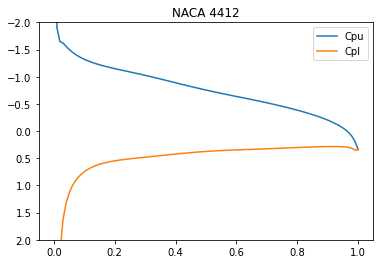

In [ ]:
airfoil1=NACA4digit(digits='4412')
model=ThinAirfoilSolver(airfoil1)
cl_sec,cm_ac_sec,y_1,y_2=model.Coef_Gen(8,Plotflag=True)

In [ ]:
# cpvsx=open('cpvsx.txt')  
# import csv
# points=csv.reader(cpvsx,delimiter='\t')
# x=[]
# cp=[]
# for i,xi in enumerate(points):
#   a=xi[0].split()
#   x.append(float(a[0]))
#   cp.append(float(a[2]))
# plt.plot(x,cp)
# x1=np.linspace(0,1,100)
# plt.plot(x1,y_1)
# plt.plot(x1,y_2)
# plt.ylim([-4,2])

####Question 3
Use the above functions repeatedly in a loop in another program to draw the $c_l − α$
curve and $c_{m,c/4} − α$ for an arbitrary (user-specified) cambered NACA 4-digit airfoil. Note that
you would NOT want to plot the pressure distribution for each data point; hence the plotting
flag was incorporated in the previous class and should be set to FALSE in the present calls.

User input for a NACA airfoil , we need to plot $c_l − α$ curve and $c_{m,c/4} − α$ . Before we get user input , we create a function to plot cl vs alpha , cm,c/4 vs alpha .

In [ ]:
def polarplotter(digits,ylim=[-5,5],xlim=[-30,30]):
  airfoil1=NACA4digit(digits=digits)
  model=ThinAirfoilSolver(airfoil1)
  x=np.linspace(xlim[0],xlim[1],61);
  cl=[]
  cm=[]
  for i in x:
    cl_sec,cm_ac_sec,_,_=model.Coef_Gen(i);
    cl.append(cl_sec)
    cm.append(cm_ac_sec)
  fig1=plt.figure(figsize=(10,10));
  ax1=fig1.add_subplot(1,1,1);
  ax1.grid();
  ax1.plot(x,cl);
  ax1.plot(x,cm);
  ax1.axes.set_xticks(np.arange(-30,34,step=4), minor=False);
  ax1.axes.set_yticks(np.arange(-4,5,step=1), minor=True);
  ax1.spines['left'].set_position('center');
  ax1.spines['bottom'].set_position('center');

  ax1.legend(['Section Lift coefficient','Section Pitching Moment coefficient']);
  ax1.set_title('Polar vs α plots for the airfoil - '+airfoil1.name);
# by returning the plot object , cl and cm arrays , we can make use of this 
# in later problems
  return [ax1,cl,cm]

The cell below when executed asks for user input as a length 4 string containing the NACA 4 digits and then plots the lift and pitching moment coefficients .

Enter the NACA digits: 3312


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


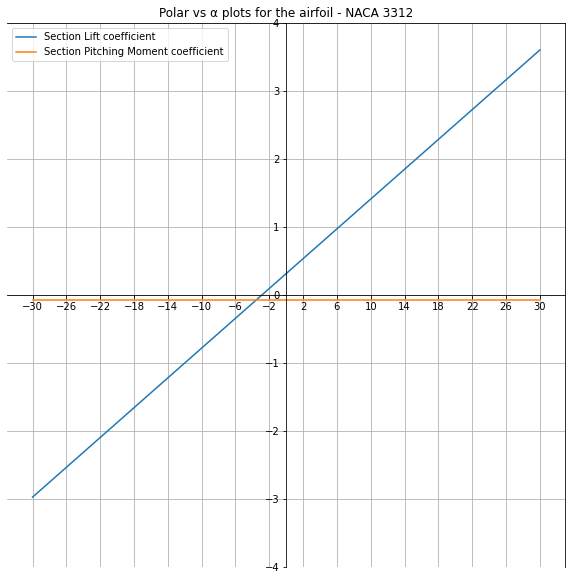

In [ ]:
NACA=input('Enter the NACA digits: ')
polarplotter(NACA);


####Question 4
 Present a detailed comparison of your results for any cambered NACA 4-digit airfoil ,
with those obtained from XFOIL (run in inviscid mode). In particular, compare the lift slope
and the $α_L=0$ value for your chosen airfoil with the XFOIL output. Also, compare your prediction of $c_{m,c/4}$ with the XFOIL result as a function of α. Finally, present the pressure coefficient
plot for $α = 8^\circ$
, and compare with the XFOIL output. Overlay your results on the XFOIL
results in the same plot for ease of verification.

Now we find $\alpha$ at L=0 i.e at c_l = 0 . For this we use the coefficients and find the inverse function for the c_l .Note that since we need only A_0 and A_1

In [ ]:
airfoil3312=NACA4digit(digits='3312')
model3312=ThinAirfoilSolver(airfoil3312,orderofA=1)
A=model3312.A

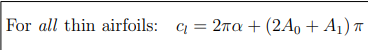

Now we use this to find alpha at cl=0
$$
\alpha=-\frac{(2A_0+A_1)\pi}{2\pi}
$$

In [ ]:
alpha_atL0_predicted=-(2*A[0]+A[1])/2
alpha_atL0_xfoil=-2.9382
error=np.abs(alpha_atL0_predicted-alpha_atL0_xfoil)
alpha_atL0_predicted

-0.050211108497575055

From xfoil , we find that $\alpha_{L=0}=-2.9382$ and from thin airfoil theory , we get $\alpha_{L=0}=-0.0502$

In [ ]:
print(error)
print("is the error for AoA at zero lift")

2.887988891502425


We can find the lift slope by fitting the plot points on a line using linear regression ( though we know that in thin airfoil theory , cl vs alpha plot is a line we do this )

In [ ]:
from scipy.stats import linregress
a=[linregress(alpha, cltft)[0],linregress(alpha, cl)[0]]
print(a)

[0.10966227112321512, 0.11747115811739817]


(0.1096, 0.1175) are the values of lift slope for thin airfoil theory and xfoil respectively.


Error for pitching moment is plotted above with a max error of around 40% of the xfoil data values . 

45.094942807802106

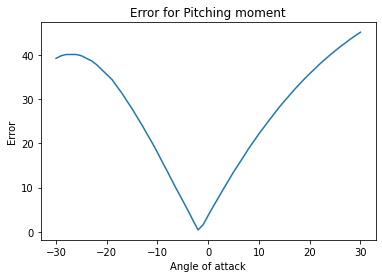

In [ ]:
cm=np.array(cm)
cmtft=np.array(cmtft)
error=np.abs((cm-cmtft)/cm*100)
plt.plot(alpha,error)
plt.title('Error for Pitching moment')
plt.xlabel('Angle of attack')
plt.ylabel('Error')
error[-1]

I choose NACA 3312 for analysis , exported xfoil data is from a temporary repo in my github page , using requests package to make this code self sufficient. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


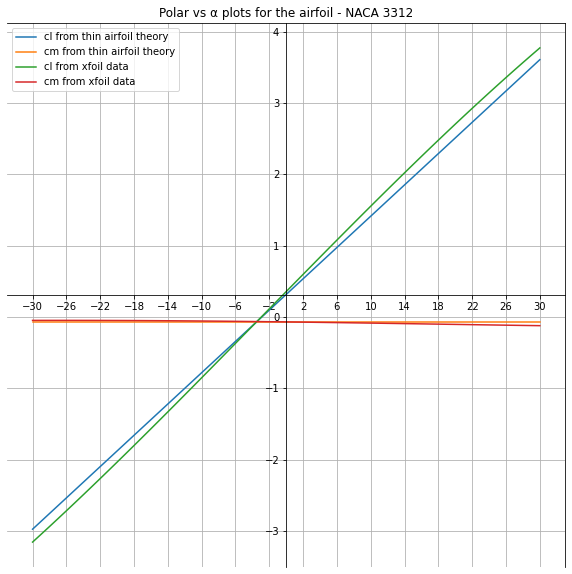

In [ ]:
import requests
URL = "https://raw.githubusercontent.com/dakseshkalewar/NACA-3312-Polar-Data/main/3312.txt"
response = requests.get(URL)
open("polaralpha.txt", "wb").write(response.content)
polarsvsalpha=open('polaralpha.txt')  
import csv
points=csv.reader(polarsvsalpha,delimiter='\t')
alpha=[]
cl=[]
cm=[]
for i,xi in enumerate(points):
  if i <=1:continue
  a=xi[0].split()
  alpha.append(float(a[0]))
  cl.append(float(a[1]))
  cm.append(float(a[4]))
ax1,cltft,cmtft=polarplotter('3312');
ax1.plot(alpha,cl)
ax1.plot(alpha,cm)
ax1.legend(['cl from thin airfoil theory','cm from thin airfoil theory','cl from xfoil data','cm from xfoil data'])


In [ ]:
print(np.abs(a[0]-a[1]))
print('is the absolute error of lift slope ')

0.0078088869941830424
is the absolute error of lift slope 


Now for the final plot , cp vs x/c , for this also i created a file in the same repo 3312cp.txt which ill use using requests package

In [ ]:
URL = "https://raw.githubusercontent.com/dakseshkalewar/NACA-3312-Polar-Data/main/3312cp.txt"
response = requests.get(URL)
open("cpvsx.txt", "wb").write(response.content)
cpvsx=open('cpvsx.txt')  
points=csv.reader(cpvsx,delimiter='\t')
x_xfoil=[]
cp_xfoil=[]
for i,xi in enumerate(points):
  if i <=1:continue
  a=xi[0].split()
  x_xfoil.append(float(a[0]))
  cp_xfoil.append(float(a[2]))


Now that we have the arrays cp for xfoil , we can use this and the thinairfoil theory object to compute cpu vs x  and cpl vs x and then plot them all , but note that we have to use the full model ( meaning 10 coefficients instead of 2 ) plot cp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Computing plotting points:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


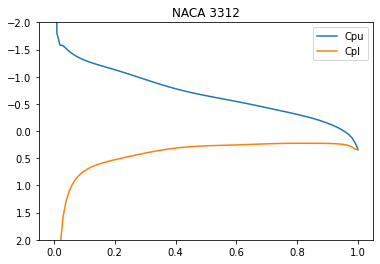

In [ ]:
model3312_full=ThinAirfoilSolver(airfoil3312)
_,_,y_1,y_2=model3312_full.Coef_Gen(alpha=8,Plotflag=True)

Now we do an overlapped plot with the x foil data 

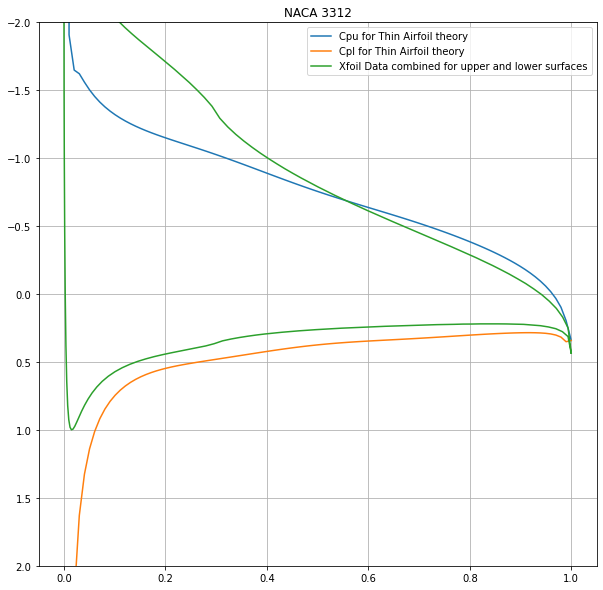

In [ ]:
x=np.linspace(0,1,100)
fig=plt.figure(figsize=(10,10));
ax=fig.add_subplot(1,1,1);
ax.plot(x,y_1);
ax.plot(x,y_2);
plt.plot(x_xfoil,cp_xfoil)
ax.legend(['Cpu for Thin Airfoil theory','Cpl for Thin Airfoil theory','Xfoil Data combined for upper and lower surfaces']);
ax.axis(ymin=-2,ymax=2);
ax.grid()
ax.set_title(airfoil3312.name);
ax.invert_yaxis()

We can hence see that there is some correlation in the plot with x foil plot 